### Imports:

In [15]:
%%capture
from read_images import ImageSeries, ConsideredPictures, RegionOfInterest

from piscat.Visualization.display_jupyter import JupyterSubplotDisplay
from piscat.InputOutput import write_video, read_tif
from piscat.Localization import particle_localization
from piscat.BackgroundCorrection import DifferentialRollingAverage, NoiseFloor
from piscat.Preproccessing import Normalization, filtering
from piscat.Visualization import JupyterSelectedPSFs_localizationDisplay, JupyterDisplay
from piscat.Trajectory.particle_linking import Linking
from piscat.Analysis import PlotProteinHistogram
from piscat.Trajectory import TemporalFilter
from piscat.Localization import localization_filtering

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


### Constructing the ImageSeries class
- The folder path where all the IRM images are stored has to be added to irm_image_path (Note: There have to be a "/" at the end of the path.
- By creating the ImageSeries class you have to pass a number of parameters to the class:
    - fps: Frame rate that was used to create the IRM pictures
    - batch_size: The number of pictures that should be averaged before creating differential images
    - region_of_interest (optional): Reduces the size of the IRM images
    - considered_pictures (optional): If not all IRM images should be considered you can choose only a section of images

In [16]:
%%capture

irm_image_path = "C:/Users/sandr/Desktop/Uni/Tuebingen/HiWi/Data/07_07_22/Rad52/run1/"
roi = RegionOfInterest(x_min=100, x_max=200, y_min=100, y_max=200)
considered_pics = ConsideredPictures(min_idx=500, max_idx=1500)
image_series = ImageSeries(path=irm_image_path,
                           fps=100,
                           batch_size=100,
                           region_of_interest=None, # region_of_interest=roi or region_of_interest=None
                           considered_pictures=None) # considered_pictures=None or considered_pictures=considered_pics
image_series.get_video()
image_series.create_differential_video()

### Saving videos
You can save the raw images, the power normalized raw images, the power fluctuation data and the differential video.
With this the computational time for the next run for the same data and the same region of interest is much shorter.

In [17]:
"""save_list = ["raw",
             "raw with power normalization",
             "power fluctuation",
             "differential video"]
image_series.save_videos(save_list)"""

'save_list = ["raw",\n             "raw with power normalization",\n             "power fluctuation",\n             "differential video"]\nimage_series.save_videos(save_list)'

### Power fluctuation
The power fluctuation within an IRM image series can be respresented in real and Fourier space.
In real space the normalized power $\frac{P}{\bar P}$ of each individual image is shown,
whereby $P$ is the power of the particular image and $\bar P$ is the averaged power over all images of the image series.
<br> In Fourier space the power spectral density (PSD) is plotted against the frequency. <br> <br>
You can choose four different plot variants:
- 1: power difference vs. frame number
- 2: Power spectrum vs. frequency (linear plot)
- 3: power spectrum vs. frequency (semi-log y plot)
- 4: power spectrum vs. frequency (log-log plot)

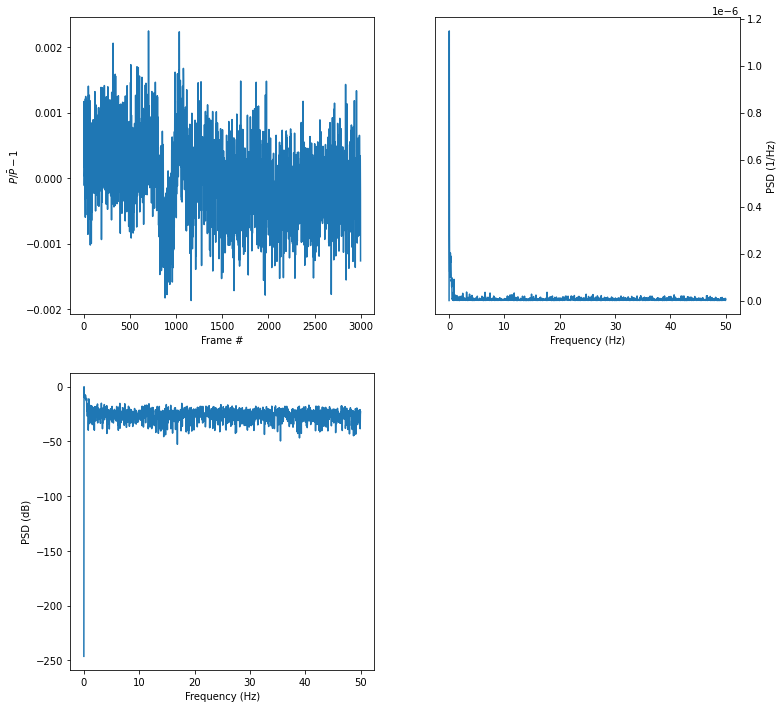

In [18]:
image_series.plot_power_fluctuation([1, 2, 3])

### Noise floor


- The noise floor function needs:
    - <font color='blue'>batch_sizes</font> for which the noise floor should be calculated.
    - <font color='blue'>modes</font> which should be used for images correction (see function description for further details).


The noise floor is running without parallel loop!

--- start DRA ---


  0%|          | 0/2997 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/2989 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/2979 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/2899 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/2799 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/2599 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/2199 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/1799 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/1399 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/999 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/599 [00:00<?, ?it/s]

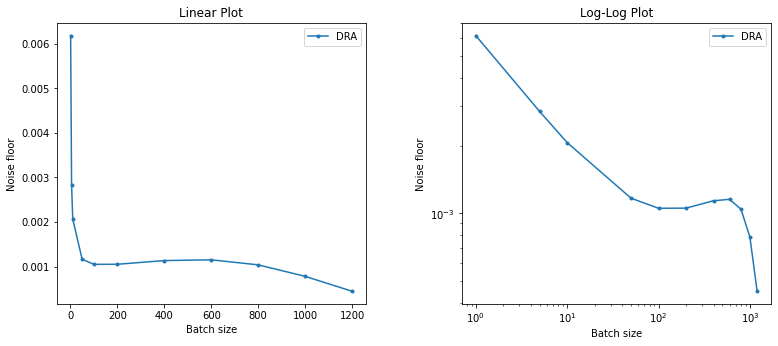

In [19]:
image_series.get_noise_floor(batch_sizes=[1, 5, 10, 50, 100, 200, 400, 600, 800, 1000, 1200],
                             modes=[0])

### Find suitable parameters for the particle detection algorithm
The "Difference of Gaussian" algorithm is described in chapter 2.3.1 of my master thesis "Interference Reflection Microscopy for Single-Molecule Detection and Mass Photometry".
Note:
- The variable $k$ in my master thesis corresponds to *sigma_ratio* in the code.
- It is possible, that more than one $\sigma_1$ is used to find particles. The amount of considered $\sigma_1$ is calculated via:<br>
$\frac{\log(\frac{max\_sigma}{min\_sigma})}{\log(sigma\_ratio + 1)} + 1$ (Decimal numbers are rounded down)
- In the code there is not only one $\sigma_1$ used, but all $\sigma_1$ within the range of *min_sigma* and *max_sigma*.

After executing the following code you can play around with the threshold value to see which parameters (min_sigma, max_sigma, sigma_ration, threshold) fit best for your sample.
here are some recommendations for different molecules:
- Rad52: min_sigma=2.3, max_sigma=2.4, sigma_ratio=4.5, threshold=5e-4,
- tubulin: min_sigma=1.8, max_sigma=1.9, sigma_ratio=3.5, threshold=2.5e-4,
- eGFP: min_sigma=1.4, max_sigma=1.5, sigma_ratio=3.5, threshold=6.2e-4,

In [20]:
frame_num = 1140
JupyterDisplay(image_series.differential_video, median_filter_flag=False, color='gray', imgSizex=5, imgSizey=5, IntSlider_width='500px', step=10)
PSF = particle_localization.PSFsExtraction(video=image_series.differential_video)
PSF.psf_detection_preview(function='dog',
                            min_sigma=2.3, max_sigma=2.3, sigma_ratio=4.5, threshold=4e-4,
                            overlap=0, mode='BOTH', frame_number=[frame_num, frame_num])

interactive(children=(IntSlider(value=10, continuous_update=False, description='Frame:', layout=Layout(width='…

interactive(children=(FloatSlider(value=0.0004, continuous_update=False, description='Threshold', layout=Layou…

### Run the particle detection algorithm
Take the parameters found in the previous step and put them into the PSFs_dog.
Particles that are found in consecutive images at quite the same positions are linked together
(search_range and memory can be set manually).
A histogram is created, which shows the number of images a particle is found in.

Frame 2799: 5 trajectories present.
Median of linking length is 23.0


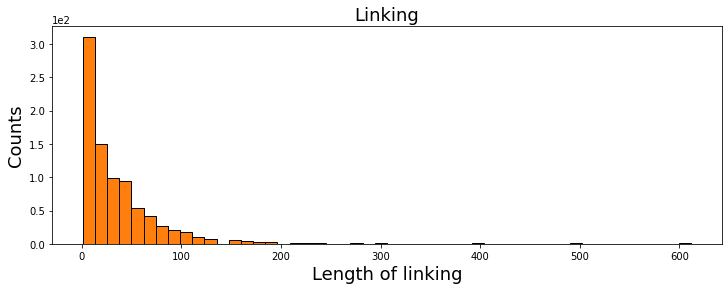

In [21]:
PSFs_dog = PSF.psf_detection(function='dog',
                            min_sigma=2.3, max_sigma=2.3, sigma_ratio=4.5, threshold=4e-4,
                            overlap=0, mode='BOTH')
PSFs = PSF.fit_Gaussian2D_wrapper(PSF_List=PSFs_dog, scale=5, internal_parallel_flag=True)
linking_ = Linking()

linked_PSFs = linking_.create_link(psf_position=PSFs,
                                   search_range=2,  # The maximum distance features can move between frames
                                   memory=10)  # The maximum number of frames during which a feature can vanish, then reappear nearby, and be considered the same particle.

his_all_particles = linked_PSFs['particle'].value_counts()

%matplotlib inline
fig = plt.figure(figsize=(12, 4))

plt.hist(his_all_particles, bins=50, fc='C1', ec='k', density=False)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Length of linking', fontsize=18)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.title('Linking', fontsize=18)
print('Median of linking length is {}'.format(np.median(his_all_particles)))
plt.show()


### Spatial and temporal filtering
You can play around with the threshold values of the spatial and temporal filters to delete registered events that probably not showing a particle (see comments and PiScat module for details).

In [22]:
spatial_filters = localization_filtering.SpatialFilter()
PSFs_filtered = spatial_filters.outlier_frames(linked_PSFs, threshold=20)  # images with more detected particles than the threshold are deleted
PSFs_filtered = spatial_filters.dense_PSFs(PSFs_filtered, threshold=10)  # particles that have a short distance to each other are deleted
PSFs_filtered = spatial_filters.symmetric_PSFs(PSFs_filtered, threshold=0.5)  # particles with non-symmetric shape are deleted

t_filters = TemporalFilter(video=image_series.differential_video, batchSize=image_series.batch_size)
all_trajectories, linked_PSFs_filter, his_all_particles = t_filters.v_trajectory(df_PSFs=PSFs_filtered, threshold=70)  # particles that are present in less images than the threshold value are deleted
print(f"Number of Particles before filtering: {linking_.trajectory_counter(linked_PSFs)}")
print(f"Number of Particles after filtering: {len(all_trajectories)}")


start removing crappy frames ---> Done!

---Cleaning the df_PSFs that have drift without parallel loop---


  0%|          | 0/2555 [00:00<?, ?it/s]


Number of PSFs before filters = 24990

Number of PSFs after filters = 24990

start V_trajectories without parallel loop---> 

  0%|          | 0/46 [00:00<?, ?it/s]

Done
Number of Particles before filtering: 855
Number of Particles after filtering: 46


### Deleting all events with no v-shape contrast
There are still events remaining which contrast can not be calculated, because they do not have a v-shape. All these events are deleted in the following.

In [23]:
%%capture

his = PlotProteinHistogram(intersection_display_flag=True, imgSizex=10, imgSizey=5)

valid_ones = []
for i in range(len(all_trajectories)):
    number = "#" + str(i)
    try:
        his.plot_contrast_extraction(particles=all_trajectories,
                                     batch_size=image_series.batch_size,
                                     video_frame_num=image_series.differential_video.shape[0],
                                     MinPeakWidth=100,
                                     MinPeakProminence=0,
                                     pixel_size=0.66,
                                     particles_num=number)
        valid_ones.append(i)
    except:
        pass

correct_trajectories = [t for i, t in enumerate(all_trajectories) if i in valid_ones]

his2 = PlotProteinHistogram(intersection_display_flag=True, imgSizex=10, imgSizey=5)
his2(folder_name='',
     particles=correct_trajectories,
     batch_size=100,
     video_frame_num=image_series.differential_video.shape[0],
     MinPeakWidth=90,
     pixel_size=0.66,
     MinPeakProminence=0)

### Visualizing contrast of particles
For each detected particle the contrast behaviour over time as well as the images wherein it was detected, are shown.

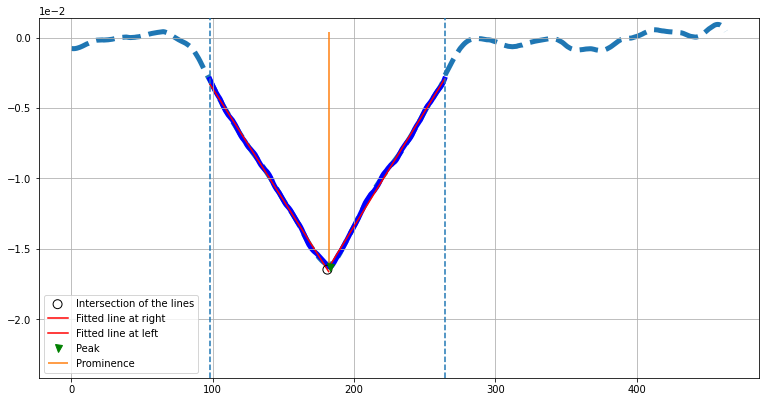

interactive(children=(IntSlider(value=98, continuous_update=False, description='Frame:', layout=Layout(width='…

In [37]:
particle_num = 0
his2.plot_contrast_extraction(particles=correct_trajectories,
                              batch_size=image_series.batch_size,
                              video_frame_num=image_series.differential_video.shape[0],
                              MinPeakWidth=90,
                              MinPeakProminence=0,
                              pixel_size=0.66,
                              particles_num="#" + str(particle_num))

# There is a problem within the plot_contrast_extraction function of the piscat module
# The next lines correct the mistake
if his2.t_contrast_peaks[particle_num] == his2.t_contrast_peaks[-1]:
    del his2.t_particle_center_intensity[-1]
    del his2.t_particle_center_intensity_follow[-1]
    del his2.tSmooth_particle_center_intensity[-1]
    del his2.tSmooth_particle_center_intensity_follow[-1]
    del his2.t_contrast_peaks[-1]
    del his2.t_contrast_peaks_index[-1]
    del his2.t_contrast_intersection[-1]
    del his2.t_contrast_intersection_index[-1]
    del his2.t_contrast_Prominence[-1]
    del his2.t_contrast_Prominence_index[-1]
    del his2.t_iPSFCentroidSigmas_[-1]
%matplotlib inline
JupyterSelectedPSFs_localizationDisplay(video=image_series.differential_video,
                                        particles=correct_trajectories,
                                        particles_num="#" + str(particle_num),
                                        frame_extend=0,
                                        median_filter_flag=True,
                                        flag_fit2D=False,
                                        color='gray',
                                        imgSizex=5,
                                        imgSizey=5)

### Particle Contrasts
All particles with their corresponding contrasts are shown.
The meaning of prominence, peak and intersection becomes obvious in the contrast plot above.

In [25]:
numbered_particles = ["# " + str(i) for i in range(len(his2.t_contrast_peaks))]
df = pd.DataFrame([numbered_particles, his2.t_contrast_peaks, his2.t_contrast_intersection, his2.t_contrast_Prominence])
df_transposed = df.T
df_transposed.columns = ['Particles', 'Peak', 'Intersection', 'Prominence']
df_transposed.style.hide_index()

Particles,Peak,Intersection,Prominence
# 0,-0.016304,-0.016478,-0.016106
# 1,-0.047337,-0.051155,-0.047552
# 2,-0.010263,-0.010355,-0.010195
# 3,-0.007466,-0.007254,-0.007251
# 4,-0.007782,-0.008006,-0.007665
# 5,0.101720,0.105280,0.100457
# 6,-0.005101,-0.004962,-0.004878
# 7,-0.003568,-0.003256,-0.003234
# 8,-0.023196,-0.022019,-0.022921
# 9,-0.005577,-0.005158,-0.005448


### Final contrast determination with Gaussian mixed model
A table is created that summarizes all results.
- The different species found are shown with their mean, standard deviation and their relative amount to all found particles.
- The table differentiates between bright and dark peaks. In general dark peaks represent particle landing, as bright peaks represent particle departures.

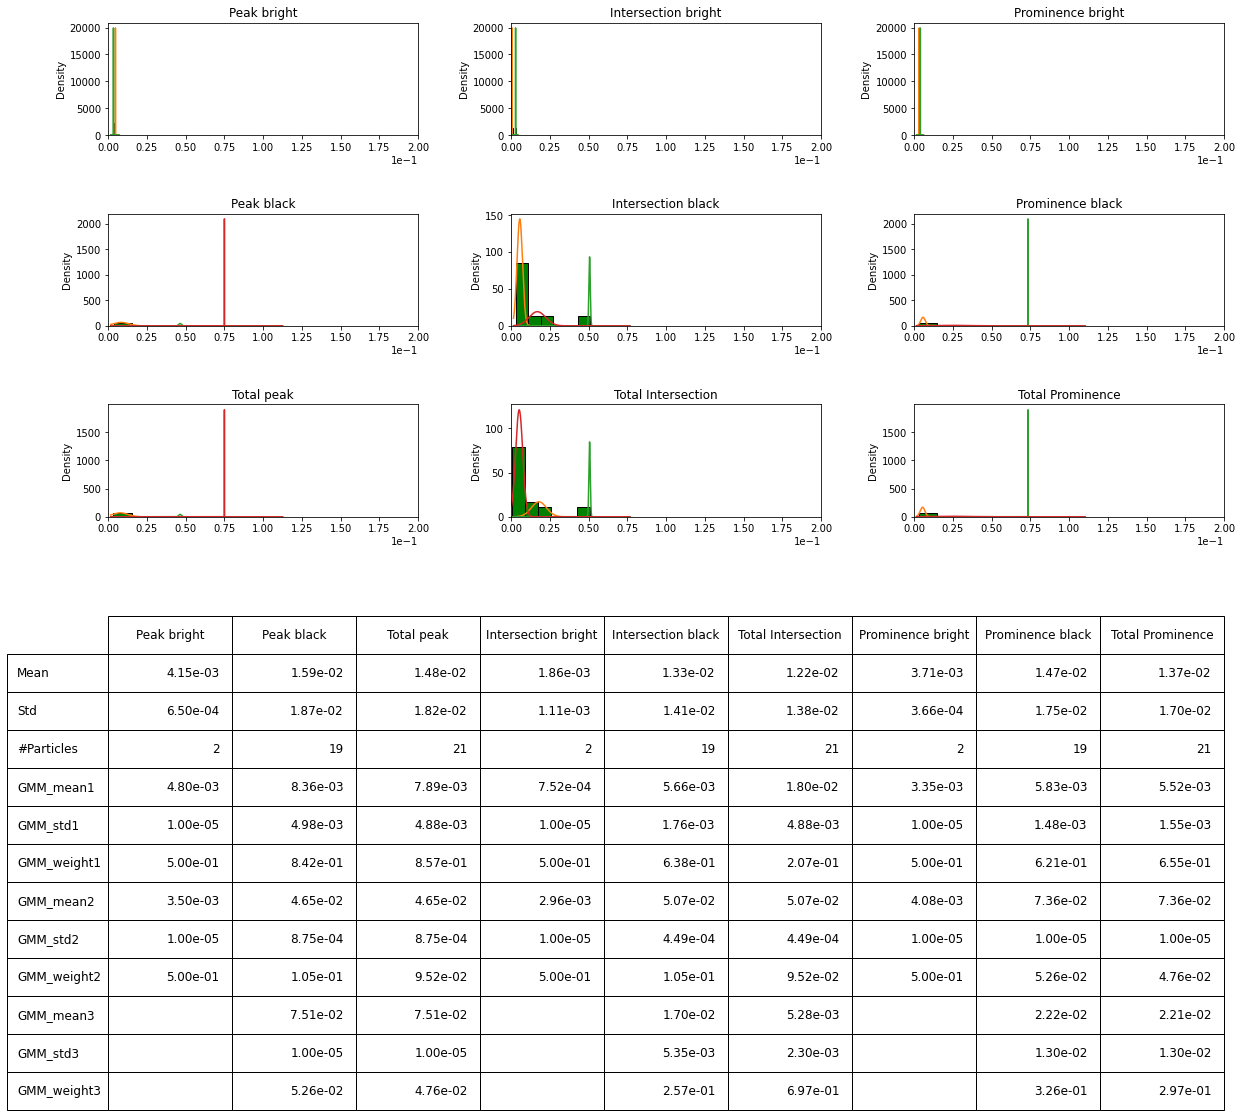

In [26]:
his2.plot_histogram(bins=6, upper_limitation=2e-2, lower_limitation=-1e-1, step_range=1e-6, face='g',
                    edge='k', Flag_GMM_fit=True, max_n_components=3, scale=1e1, external_GMM=False)
